# Chapter 4

## 4.1 Train a model for predicting churn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:

df = pd.read_csv('ch4_dataset.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
#make your numerical and categorical lists
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Checking for accuracy on dummy models

In [8]:
#How many customers do we have?
len(y_val)

1409

In [11]:
#How many decisions were correct?
(y_val == churn_decision).sum()

1132

In [12]:
#Accuracy is equal to
1132/1409

0.8034066713981547

## Accuracy Score

In [13]:
#can use accuracy from SciKit-Learn with a churn threshold of 50%
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [15]:
#to look at various thresholds... look at highest value in second row
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


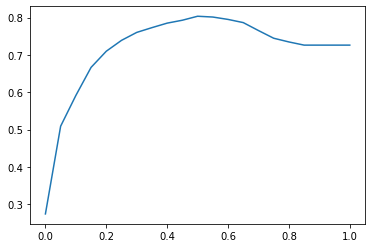

In [16]:
plt.plot(thresholds, scores)

In [17]:
from collections import Counter

In [18]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [19]:
#to see how many are non-churning
1 - y_val.mean()

0.7260468417317246

# Confusion table

In [20]:
#actual positive is when we correctly predicted they will churn
#actual negative is when we correctedly predicted they will stay (not churn)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [21]:
#t is threshold
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [22]:
#tp = true positive  - they correctly churned
#tn = true negative  - they correctly did not churn
#fp = false positive  - we predicted they would churn but they stayed
#fn = false negative  - we predicted they would stay and they left
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [23]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [24]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [25]:
#15% we correctly predicted they would churn and they did churn
#65% we correctly predicted they would not churn and they did not churn
#7% we incorrectly predicted they would churn but they stayed
#12% we incorrectly predicted they would stay and they left

# Precision and Recall

In [26]:
#Precision tells us the fraction of positive predictions that turned out to be correct
p = tp / (tp + fp)
p

0.6752411575562701

In [27]:
#Recall is the fraction of correctly identified positive examples
r = tp / (tp + fn)
r

0.5440414507772021

In [28]:
#Precision is 67%... so it's a pretty precise model for predicting but
#Recall is 54%... so for 46% that are churning, and we didn't predict this.
#which means our accuracy of 80% isn't a good measure of saying this model
#is good or not. It's actually not a good model because of the Recall.

# ROC curves

###  True Positive Rate (TPR) and False Positive Rate (FPR)

In [30]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [31]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [32]:
#compute for all possible balues
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [35]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,75,20,311,1003,0.194301,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


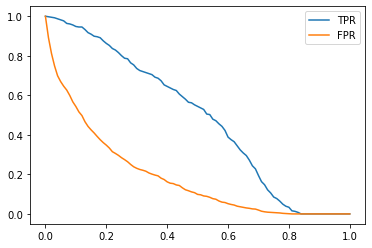

In [36]:
#plot them

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [37]:
#you want the TPR to be as high as possible
#you want FPR to go down quickly and be as low as possible

# Random model

In [38]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [39]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [40]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [41]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

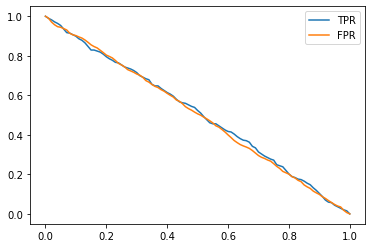

In [42]:
#plot the random model
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

# Ideal model

In [43]:
num_neg = (y_val == 0).sum()  #number not churning
num_pos = (y_val == 1).sum()   #number churning
num_neg, num_pos

(1023, 386)

In [44]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [45]:
1 - y_val.mean()

0.7260468417317246

In [46]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [47]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


#look above and see that 72 is between the 70 and 80 row
#try to get fp of 0 and tn of 0

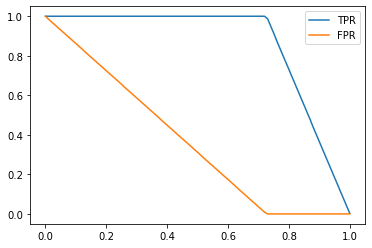

In [48]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

In [49]:
#pretty!
#draw a vertical line at the top blue where it starts to drop
#to the bottom orange where it turns flat
#.726 is best threshold

# Putting it all together

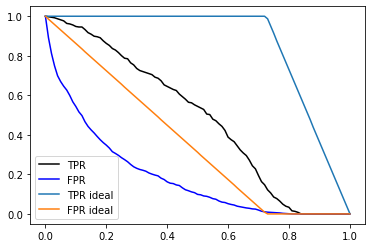

In [50]:

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

#don't really need random ones
# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

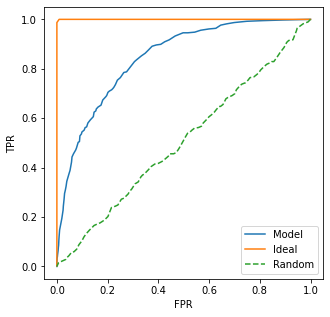

In [53]:
#plot tpr and fpr
plt.figure(figsize=(5, 5))   #to make ROC curve chart square in shape

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random', linestyle='--')
#can also do this for random line
#plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# ROC curve plotting

In [54]:
#can also do ROC curve this way
from sklearn.metrics import roc_curve

In [55]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

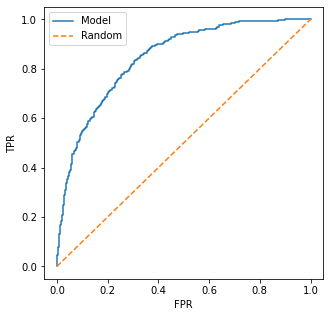

In [56]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# Area under the ROC curve

In [57]:
from sklearn.metrics import auc

In [58]:
auc(fpr, tpr)

0.8438530381535562

In [59]:
#we want the value above 0.8, to be closer to 1.
# I think this is all the code we want but he went into other ways
# to calculate it

In [60]:
#this is when computed manually, don't use!
auc(df_scores.fpr, df_scores.tpr)

0.8437454099747264

In [61]:
#for ideal.. should be close to 1
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [62]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438530381535562

In [63]:
#more code in ch soutions file
# https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/04-evaluation/notebook.ipynb

# Cross-validation

### Evaluating the same model on different subsets of data
### Getting the average prediction and the spread within predictions


In [64]:
#create a function for training
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [65]:
dv, model = train(df_train, y_train, C=0.001)

In [66]:
#create a function for predicting
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [67]:
y_pred = predict(df_val, dv, model)

In [68]:
from sklearn.model_selection import KFold

In [69]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)


In [75]:
#only need to do this once
#!pip install tqdm

In [77]:
from tqdm.auto import tqdm

In [78]:

n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.007
C=0.5 0.841 +- 0.007
C=1 0.840 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


In [79]:
scores

[0.8425595214732595,
 0.8447991160111245,
 0.8333493879189244,
 0.8323147822472341,
 0.8525462018763139]

In [80]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259